In [1]:
import pandas as pd, geopandas as gpd
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
FVSIn='postgresql://postgres@localhost:5432/PNWFIADB_FVSIn'
FVSOut='postgresql://postgres@localhost:5432/PNWFIADB_FVSOut'

In [3]:
climate = pd.read_csv('PNWFIA_DF_plots_1989-2015_ClimateWNA.csv')

In [4]:
climate.head()

,Year,id1,id2,Latitude,Longitude,Elevation,Tmax01,Tmax02,Tmax03,Tmax04,...,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,MAR,RH
0,1989,10775507020004,NaN,43.045378,-123.905342,457.20,8.8,7.3,11.8,17.2,...,103,310,207,39,-13.5,38.0,895,394,14.3,64
1,1989,12393556010497,NaN,41.634495,-123.785782,518.16,8.6,9.4,11.0,19.0,...,121,290,170,63,-18.6,40.4,1063,539,0.0,55
2,1989,12778284010497,NaN,45.251447,-118.964180,1249.68,2.2,-2.3,6.2,12.5,...,153,262,108,182,-30.0,36.6,749,417,15.7,59
3,1989,12778644010497,NaN,45.455118,-118.277458,1005.84,1.4,-3.1,6.2,13.0,...,150,263,113,250,-29.3,37.1,773,394,14.7,58
4,1989,12778871010497,NaN,45.540632,-118.474861,1188.72,1.5,-3.8,5.1,12.4,...,147,272,126,266,-28.5,36.7,731,359,15.6,62


In [25]:
cols = ['Year', 'id1', 'MAT', 'MWMT', 'MCMT', 'MAP', 'AHM', 'SHM', 
        'MAR', 'RH', 'CMD', 'Eref', 'PAS', 'NFFD', 'DD5', 'DD18', 'DD_18']
wna = climate[cols].copy()
matmap = climate[['Year', 'id1', 'MAT', 'MAP']].rename({'id1':'plot_id'}, axis='columns')
wna = wna.rename({'id1':'plot_id'}, axis='columns')

In [7]:
wna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378675 entries, 0 to 378674
Data columns (total 17 columns):
Year       378675 non-null int64
plot_id    378675 non-null int64
MAT        378675 non-null float64
MWMT       378675 non-null float64
MCMT       378675 non-null float64
MAP        378675 non-null int64
AHM        378675 non-null float64
SHM        378675 non-null float64
MAR        378675 non-null float64
RH         378675 non-null int64
CMD        378675 non-null int64
Eref       378675 non-null int64
PAS        378675 non-null int64
NFFD       378675 non-null int64
DD5        378675 non-null int64
DD18       378675 non-null int64
DD_18      378675 non-null int64
dtypes: float64(6), int64(11)
memory usage: 49.1 MB


In [8]:
avg_climate = wna.groupby('plot_id').mean().reset_index().drop('Year', axis=1)

In [9]:
avg_climate.head()

,plot_id,MAT,MWMT,MCMT,MAP,AHM,SHM,MAR,RH,CMD,Eref,PAS,NFFD,DD5,DD18,DD_18
0,5931423010901,5.551852,15.500000,-3.014815,2463.037037,6.440741,43.474074,9.385185,67.037037,184.111111,598.518519,727.814815,193.518519,1255.148148,34.703704,4553.703704
1,5936567010901,5.874074,18.170370,-4.000000,704.148148,23.170370,83.388889,12.533333,65.851852,323.629630,649.333333,203.518519,190.333333,1487.925926,91.814815,4489.851852
2,8600844010901,10.922222,19.433333,4.240741,2956.333333,7.577778,83.537037,0.000000,64.037037,425.037037,935.518519,88.407407,291.629630,2374.814815,200.148148,2760.185185
3,8601029010901,8.396296,20.362963,-1.751852,651.407407,28.959259,132.633333,12.785185,63.000000,472.370370,804.148148,101.777778,225.740741,1985.555556,195.703704,3671.259259
4,8601215010901,7.437037,19.077778,-2.207407,1175.444444,15.322222,101.874074,11.300000,66.185185,367.111111,718.074074,260.703704,220.037037,1733.592593,126.296296,3952.444444


In [121]:
SQL = '''
SELECT 
plot.cn AS plot_id, subplot.cn AS subplot_id, tree.cn AS tree_cn, tree.tree AS tree_id,
measyear, fvsvariant as region, tree.dia as dbh, 
tree.inc10yr_pnwrs/20.*25.4*2 AS diamincr_mm, tree.inc10yr_pnwrs/20.*2 as dg_in
FROM plot, subplot, tree, fvs_locations
WHERE plot.cn = tree.plt_cn AND subplot.plt_cn = plot.cn AND
tree.subp = subplot.subp AND plot.cn = fvs_locations.plt_cn AND 
tree.spcd = 202 AND tree.dia IS NOT NULL AND tree.cr IS NOT NULL AND
tree.inc10yr_pnwrs IS NOT NULL AND subplot.slope IS NOT NULL AND
subplot.aspect IS NOT NULL AND plot.measyear <= 2015
GROUP BY region, plot_id, subplot_id, measyear, 
tree_cn, tree_id, tree.dia, tree.inc10yr_pnwrs
'''
fia = pd.read_sql(sql=SQL, con=FVSIn)

In [122]:
ids = ['plot_id', 'subplot_id', 'tree_id']
fia[ids] = fia[ids].astype('int64')
fia.head()

,plot_id,subplot_id,tree_cn,tree_id,measyear,region,dbh,diamincr_mm,dg_in
0,13047360010497,13047405010497,13047462010497,132,2005,AK,5.4,63.50,2.5
1,13047360010497,13047405010497,13047498010497,125,2005,AK,7.5,121.92,4.8
2,13047360010497,13047405010497,13047501010497,126,2005,AK,6.7,99.06,3.9
3,13047360010497,13047405010497,13047504010497,127,2005,AK,7.5,121.92,4.8
4,13047360010497,13047405010497,13047543010497,124,2005,AK,8.3,134.62,5.3


In [123]:
data = pd.merge(left=fia, right=avg_climate, how='left', on='plot_id')

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36432 entries, 0 to 36431
Data columns (total 24 columns):
plot_id        36432 non-null int64
subplot_id     36432 non-null int64
tree_cn        36432 non-null object
tree_id        36432 non-null int64
measyear       36432 non-null int64
region         36432 non-null object
dbh            36432 non-null float64
diamincr_mm    36432 non-null float64
dg_in          36432 non-null float64
MAT            36432 non-null float64
MWMT           36432 non-null float64
MCMT           36432 non-null float64
MAP            36432 non-null float64
AHM            36432 non-null float64
SHM            36432 non-null float64
MAR            36432 non-null float64
RH             36432 non-null float64
CMD            36432 non-null float64
Eref           36432 non-null float64
PAS            36432 non-null float64
NFFD           36432 non-null float64
DD5            36432 non-null float64
DD18           36432 non-null float64
DD_18          36432 non-nu

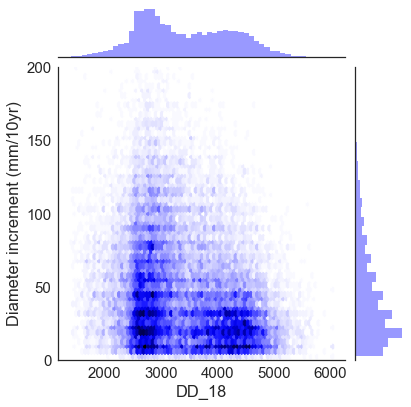

In [23]:
sns.set(font_scale=1.5)
with sns.axes_style("white"): 
    g = sns.jointplot(x=data.DD_18, y=data.diamincr_mm, kind="hex", stat_func=None, color="b")
    #g.ax_joint.set_xlim(0, 1)
    g.ax_joint.set_ylim(0,200)
    g.ax_joint.set_yticks([0,50,100,150,200])
    g.ax_joint.set_ylabel('Diameter increment (mm/10yr)')
    
    #g.ax_joint.set_xlabel('Mean Annual Precipitation (mm)')
    #g.ax_joint.set_xticks([0,5,10,15])
    
    #g.savefig('MAP.png');

In [159]:
df = pd.merge(fia, matmap, how='left', on='plot_id')
df['year_diff'] = df.measyear - df.Year
df = df.loc[df.year_diff<=10]
grouping = ['plot_id', 'subplot_id', 'measyear', 'tree_cn', 'tree_id', 'dbh', 'dg_in'] 
df = df.groupby(by=grouping).mean().drop(['Year', 'year_diff'], axis=1).reset_index()
df.head()

,plot_id,subplot_id,measyear,tree_cn,tree_id,dbh,dg_in,diamincr_mm,MAT,MAP
0,5931423010901,5931430010901,2004,5931443010901,101,44.5,1.2,30.48,5.550000,2486.500000
1,5931423010901,5931432010901,2004,5931489010901,124,29.2,1.1,27.94,5.550000,2486.500000
2,5936567010901,5936575010901,2004,5936598010901,102,21.0,1.3,33.02,5.972727,716.454545
3,5936567010901,5936577010901,2004,5936610010901,112,20.0,2.4,60.96,5.972727,716.454545
4,5936567010901,5936578010901,2004,5936618010901,116,24.5,0.6,15.24,5.972727,716.454545


In [160]:
len(df)

36432

In [161]:
SQL = '''
SELECT stand_id AS subplot_id, inv_year AS measyear, slope, 
aspect, elevft as elev
FROM fvs_standinit
WHERE slope IS NOT NULL AND aspect IS NOT NULL
AND elevft IS NOT NULL
'''
site = pd.read_sql(sql=SQL, con=FVSIn)

In [162]:
df = df.merge(site, how='inner', on=['subplot_id', 'measyear'])
len(df)

36432

In [163]:
SQL = '''
SELECT standid AS subplot_id, treeid AS tree_id, dg AS dg_in, year as measyear, dbh, ptbal as bal,
pctcr/100. as cr
FROM treelist
WHERE prdlen = 10 AND dg >0 AND (species = 'DF' OR species = 'OS')
'''
trees = pd.read_sql(sql=SQL, con=FVSOut)
trees[['subplot_id', 'tree_id']] = trees[['subplot_id', 'tree_id']].astype('int64')

In [164]:
df = df.merge(trees, how='inner', on=['subplot_id', 'measyear', 'tree_id', 'dbh'])
len(df)

36415

In [165]:
SQL = '''
SELECT standid as subplot_id, year as measyear, SUM(0.005454* DBH^2 * (tpa + mortpa)) AS BA
FROM treelist
WHERE prdlen = 10
GROUP BY standid, year
'''
BA = pd.read_sql(sql=SQL, con=FVSOut)
BA['subplot_id'] = BA['subplot_id'].astype('int64')

In [168]:
df = df.merge(BA, how='inner', on=['subplot_id', 'measyear'])

In [169]:
df.head()

,plot_id,subplot_id,measyear,tree_cn,tree_id,dbh,dg_in_x,diamincr_mm,MAT,MAP,slope,aspect,elev,dg_in_y,bal,cr,ba
0,5931423010901,5931430010901,2004,5931443010901,101,44.5,1.2,30.48,5.550000,2486.500000,95.0,265.0,3700,0.60,0.0,0.45,61.933283
1,5931423010901,5931432010901,2004,5931489010901,124,29.2,1.1,27.94,5.550000,2486.500000,95.0,320.0,3700,0.55,22.0,0.40,114.766495
2,5936567010901,5936575010901,2004,5936598010901,102,21.0,1.3,33.02,5.972727,716.454545,45.0,159.0,5900,0.65,0.0,0.90,25.491535
3,5936567010901,5936577010901,2004,5936610010901,112,20.0,2.4,60.96,5.972727,716.454545,49.0,288.0,5900,1.20,15.0,0.80,33.913766
4,5936567010901,5936578010901,2004,5936618010901,116,24.5,0.6,15.24,5.972727,716.454545,45.0,140.0,5900,0.30,0.0,0.90,5.758093


In [171]:
df.to_csv('DF_for_fitting.csv', header=True, index=False)